# Heart Disease

From the Kaggle competition: https://www.kaggle.com/ronitf/heart-disease-uci/home

### Attribute Information: 
> 1. age 
> 2. sex 
> 3. chest pain type (4 values) 
> 4. resting blood pressure 
> 5. serum cholestoral in mg/dl 
> 6. fasting blood sugar > 120 mg/dl
> 7. resting electrocardiographic results (values 0,1,2)
> 8. maximum heart rate achieved 
> 9. exercise induced angina 
> 10. oldpeak = ST depression induced by exercise relative to rest 
> 11. the slope of the peak exercise ST segment 
> 12. number of major vessels (0-3) colored by flourosopy 
> 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve

In [2]:
raw = pd.read_csv("heart.csv").sample(frac=1).reset_index(drop=True)
raw.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
1,64,1,3,170,227,0,0,155,0,0.6,1,0,3,1
2,59,1,3,170,288,0,0,159,0,0.2,1,0,3,0
3,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
4,62,1,2,130,231,0,1,146,0,1.8,1,3,3,1


In [3]:
feature_columns = [col for col in raw.columns if col <> "target"]
X = raw[feature_columns].to_numpy()
y = raw["target"].to_numpy()

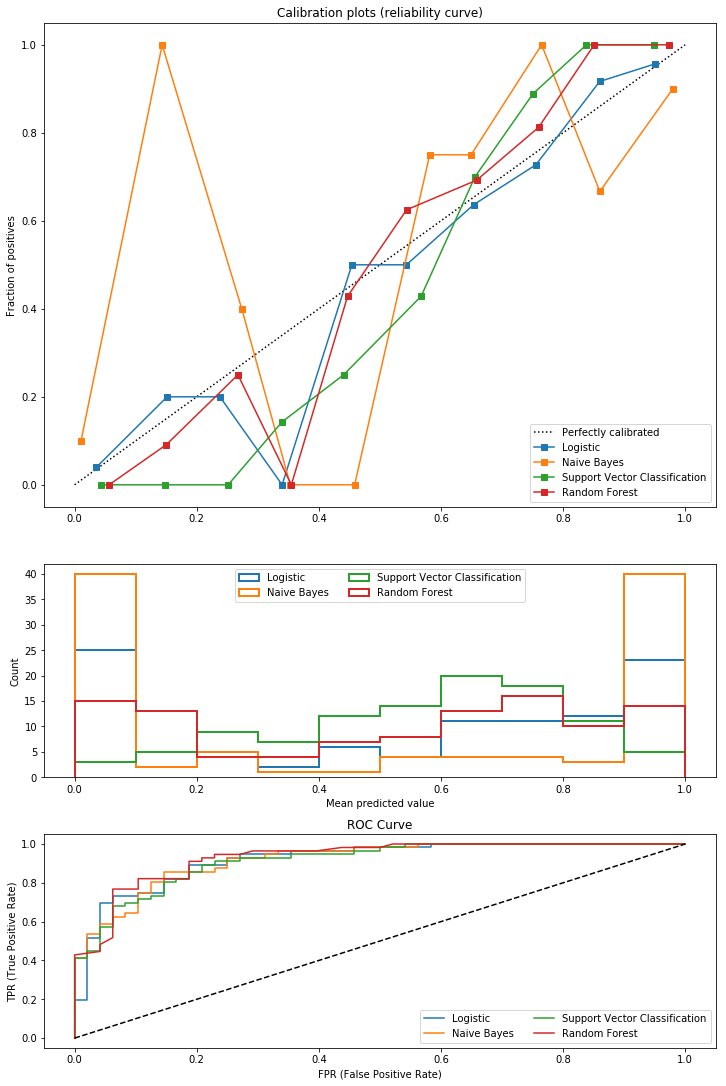

In [10]:
train_samples = int(len(y)*0.66)

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 15))
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((4, 1), (2, 0))
ax3 = plt.subplot2grid((4, 1), (3, 0))


ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
    fpr_rt, tpr_rt, _ = roc_curve(y_test, prob_pos)
    
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    ax3.plot(fpr_rt, tpr_rt, label="%s" % (name, ))

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_title("ROC Curve")
ax3.set_xlabel("FPR (False Positive Rate)")
ax3.set_ylabel("TPR (True Positive Rate)")
ax3.legend(loc="lower right", ncol=2)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()